In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

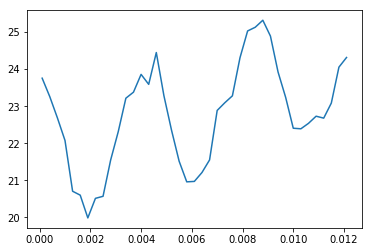

In [2]:
data = pd.read_table('datasets/B=209_t,qm,bm.dat',header = None,delimiter=',',names=['time','qm','bm','d'])
# data1 = pd.read_table('datasets/B=209_d1.dat',header = None,delimiter=',',names=['a','b','c','d'])
# data2 = pd.read_table('datasets/B=209_d2.dat',header = None,delimiter=',',names=['a','b','c','d'])
# data3 = pd.read_table('datasets/B=209_d3.dat',header = None,delimiter=',',names=['a','b','c','d'])
# data4 = pd.read_table('datasets/B=209_d4.dat',header = None,delimiter=',',names=['a','b','c','d'])
# data5 = pd.read_table('datasets/B=209_d5.dat',header = None,delimiter=',',names=['a','b','c','d'])
plt.plot(data['time'],data['qm'])
# plt.plot(data1['a'],data1['b'])
# plt.plot(data2['a'],data2['b'])
# plt.plot(data3['a'],data3['b'])
# plt.plot(data4['a'],data4['b'])
# plt.plot(data5['a'],data5['b'])
plt.show()

In [3]:
time = 2*np.pi*125*np.asarray(data['time'])
time.reshape(-1,1)

array([[0.07853982],
       [0.31415927],
       [0.54977871],
       [0.78539816],
       [1.02101761],
       [1.25663706],
       [1.49225651],
       [1.72787596],
       [1.96349541],
       [2.19911486],
       [2.43473431],
       [2.67035376],
       [2.9059732 ],
       [3.14159265],
       [3.3772121 ],
       [3.61283155],
       [3.848451  ],
       [4.08407045],
       [4.3196899 ],
       [4.55530935],
       [4.7909288 ],
       [5.02654825],
       [5.26216769],
       [5.49778714],
       [5.73340659],
       [5.96902604],
       [6.20464549],
       [6.44026494],
       [6.67588439],
       [6.91150384],
       [7.14712329],
       [7.38274274],
       [7.61836218],
       [7.85398163],
       [8.08960108],
       [8.32522053],
       [8.56083998],
       [8.79645943],
       [9.03207888],
       [9.26769833],
       [9.50331778]])

In [15]:
prev_mse = 100000 
#time = np.asarray(data['time'])
time = 2*np.pi*125*np.asarray(data['time'])
qm =  np.asarray(data['qm'])
n_epochs = 10000
adaptive_learn_rate = tf.placeholder(tf.float32,name='adaptive_learn_rate')
batch_size = 15
n_batches = int(np.ceil(len(time/batch_size)))

def fetch_batch(epoch, batch_index, batch_size):
    
    np.random.seed(epoch*batch_index)
    
    idx = np.random.randint(len(time),size = batch_size)
    
    X_batch = time[idx].reshape(-1,1)
    y_batch = qm[idx].reshape(-1,1)

    return X_batch,y_batch

X = tf.placeholder(tf.float32, shape = (None, 1), name = 'X')
y = tf.placeholder(tf.float32, shape = (None,1),name = 'y')
t = tf.constant(time.reshape(-1,1), dtype=tf.float32, name = 't')
yf = tf.constant(qm.reshape(-1,1),dtype=tf.float32,name='y')
amp1 = tf.Variable(tf.random_uniform([1,1],-10.0,10.0),name='amp1')
amp2 = tf.Variable(tf.random_uniform([1,1],-10.0,10.0),name='amp2')
offset = tf.Variable(tf.random_uniform([1,1],-1.75*np.mean(qm),1.75*np.mean(qm)),name='offset')
f1 = tf.Variable(tf.random_uniform([1,1],-2.3,2.3),name='f1')
g1 = tf.Variable(tf.random_uniform([1,1],0.0,10.0),name='g1')
g2 = tf.Variable(tf.random_uniform([1,1],0.0,10.0),name='g2')
p1 = tf.Variable(tf.random_uniform([1,1],0,2*np.pi),name='p1')
# term1osc = tf.multiply(amp1,tf.cos(f1*t + p1,name='hydroosc'),name = 'term1osc')
# term1damp = tf.exp(-g1*t,name='hydrodamp')
term1osc = tf.multiply(amp1,tf.cos(f1*X + p1,name='hydroosc'),name = 'term1osc')
term1damp = tf.exp(-g1*X,name='hydrodamp')
term1 = tf.multiply(term1osc,term1damp,name = 'term1')
# term2 = tf.multiply(amp2,tf.exp(-g2*t,name='hydrodamp'),name = 'term2')
term2 = tf.multiply(amp2,tf.exp(-g2*X,name='hydrodamp'),name = 'term2')
no_offset = tf.add(term1,term2,name='no_offset')
y_pred = tf.add(no_offset,offset,name = 'predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error),name='mse')
optimizer = tf.train.GradientDescentOptimizer(learning_rate=adaptive_learn_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    
    sess.run(init)
    
    yact=yf.eval().reshape(-1,1)  
    
    for epoch in range(n_epochs):

        
        for batch_index in range(n_batches):
                  
            X_batch, y_batch = fetch_batch(epoch,batch_index,batch_size)
            
            if epoch <3000:
                sess.run(training_op,feed_dict = {X: X_batch, y: y_batch,adaptive_learn_rate:0.02})
            elif epoch < 6000:
                sess.run(training_op,feed_dict = {X: X_batch, y: y_batch,adaptive_learn_rate:0.005})
            else:
                sess.run(training_op,feed_dict = {X: X_batch, y: y_batch,adaptive_learn_rate:0.001})
            current_mse = mse.eval(feed_dict = {X:time.reshape(-1,1),y:yact})

                    
            if epoch % 1000 == 0:
            
                print('Epoch', epoch, 'MSE',current_mse)
                
            if current_mse < prev_mse:
                
                prev_mse = current_mse
                
                #print('current best',prev_mse)
                
#     for epoch in range(n_epochs):
        
#         if epoch % 100 == 0:
            
#             print('Epoch', epoch, 'MSE', mse.eval())
            
#         sess.run(training_op)
      
                nh_best_y = y_pred.eval(feed_dict={X:time.reshape(-1,1),y:yact})
                nh_best_amp1 = amp1.eval()
                nh_best_amp2 = amp2.eval()
                nh_best_offset = offset.eval()
                nh_best_f1 = f1.eval()
                nh_best_g1 = g1.eval()
                nh_best_g2 = g2.eval()
                nh_best_p1 = p1.eval()
                
            
    nh_best_mse = prev_mse
        
prev_mse = 100000 
#time = np.asarray(data['time'])
time = 2*np.pi*125*np.asarray(data['time'])
qm =  np.asarray(data['qm'])
n_epochs = 10000
adaptive_learn_rate = tf.placeholder(tf.float32,name='adaptive_learn_rate')
batch_size = 15
n_batches = int(np.ceil(len(time/batch_size)))

def fetch_batch(epoch, batch_index, batch_size):
    
    np.random.seed(epoch*batch_index)
    
    idx = np.random.randint(len(time),size = batch_size)
    
    X_batch = time[idx].reshape(-1,1)
    y_batch = qm[idx].reshape(-1,1)

    return X_batch,y_batch


X = tf.placeholder(tf.float32, shape = (None, 1), name = 'X')
y = tf.placeholder(tf.float32, shape = (None,1),name = 'y')
t = tf.constant(time.reshape(-1,1), dtype=tf.float32, name = 't')
yf = tf.constant(qm.reshape(-1,1),dtype=tf.float32,name='y')
amp1 = tf.Variable(tf.random_uniform([1,1],-10.0,10.0),name='amp1')
amp2 = tf.Variable(tf.random_uniform([1,1],-10.0,10.0),name='amp2')
offset = tf.Variable(tf.random_uniform([1,1],-1.75*np.mean(qm),1.75*np.mean(qm)),name='offset')
f1 = tf.Variable(tf.random_uniform([1,1],-2.3,2.3),name='f1')
g1 = tf.Variable(tf.random_uniform([1,1],0.0,10.0),name='g1')
g2 = tf.Variable(tf.random_uniform([1,1],0.0,10.0),name='g2')
p1 = tf.Variable(tf.random_uniform([1,1],0,2*np.pi),name='p1')
# term1osc = tf.multiply(amp1,tf.cos(f1*t + p1,name='hydroosc'),name = 'term1osc')
# term1damp = tf.exp(-g1*t,name='hydrodamp')
term1osc = tf.multiply(amp1,tf.cos(f1*X + p1,name='hydroosc'),name = 'term1osc')
term1damp = tf.exp(-g1*X,name='hydrodamp')
term1 = tf.multiply(term1osc,term1damp,name = 'term1')
# term2 = tf.multiply(amp2,tf.exp(-g2*t,name='hydrodamp'),name = 'term2')
#term2 = tf.multiply(amp2,tf.exp(-g2*X,name='hydrodamp'),name = 'term2')
no_offset = tf.add(term1,0,name='no_offset')
y_pred = tf.add(no_offset,offset,name = 'predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error),name='mse')
optimizer = tf.train.GradientDescentOptimizer(learning_rate=adaptive_learn_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    
    sess.run(init)
    
    yact=yf.eval().reshape(-1,1)  
    
    for epoch in range(n_epochs):

        
        for batch_index in range(n_batches):
                  
            X_batch, y_batch = fetch_batch(epoch,batch_index,batch_size)
            
            if epoch <3000:
                sess.run(training_op,feed_dict = {X: X_batch, y: y_batch,adaptive_learn_rate:0.02})
            elif epoch < 6000:
                sess.run(training_op,feed_dict = {X: X_batch, y: y_batch,adaptive_learn_rate:0.005})
            else:
                sess.run(training_op,feed_dict = {X: X_batch, y: y_batch,adaptive_learn_rate:0.001})
            current_mse = mse.eval(feed_dict = {X:time.reshape(-1,1),y:yact})

                    
            if epoch % 1000 == 0:
            
                print('Epoch', epoch, 'MSE',current_mse)
                
            if current_mse < prev_mse:
                
                prev_mse = current_mse
                
                #print('current best',prev_mse)
                
#     for epoch in range(n_epochs):
        
#         if epoch % 100 == 0:
            
#             print('Epoch', epoch, 'MSE', mse.eval())
            
#         sess.run(training_op)
      
                h_best_y = y_pred.eval(feed_dict={X:time.reshape(-1,1),y:yact})
                h_best_amp1 = amp1.eval()
                #h_best_amp2 = amp2.eval()
                h_best_offset = offset.eval()
                h_best_f1 = f1.eval()
                h_best_g1 = g1.eval()
                #h_best_g2 = g2.eval()
                h_best_p1 = p1.eval()
                
            
    h_best_mse = prev_mse

Epoch 0 MSE 277.89798
Epoch 0 MSE 256.5872
Epoch 0 MSE 236.9397
Epoch 0 MSE 218.82478
Epoch 0 MSE 202.12228
Epoch 0 MSE 186.72133
Epoch 0 MSE 172.51979
Epoch 0 MSE 159.42366
Epoch 0 MSE 147.34633
Epoch 0 MSE 136.20793
Epoch 0 MSE 125.93494
Epoch 0 MSE 116.459625
Epoch 0 MSE 107.71955
Epoch 0 MSE 99.65722
Epoch 0 MSE 92.219635
Epoch 0 MSE 85.35794
Epoch 0 MSE 79.02717
Epoch 0 MSE 73.18585
Epoch 0 MSE 67.795784
Epoch 0 MSE 62.82176
Epoch 0 MSE 58.23133
Epoch 0 MSE 53.9946
Epoch 0 MSE 50.083996
Epoch 0 MSE 46.47412
Epoch 0 MSE 43.14158
Epoch 0 MSE 40.06481
Epoch 0 MSE 37.223923
Epoch 0 MSE 34.60058
Epoch 0 MSE 32.17789
Epoch 0 MSE 29.940275
Epoch 0 MSE 27.873396
Epoch 0 MSE 25.964006
Epoch 0 MSE 24.199915
Epoch 0 MSE 22.56989
Epoch 0 MSE 21.063547
Epoch 0 MSE 19.671337
Epoch 0 MSE 18.384453
Epoch 0 MSE 17.194752
Epoch 0 MSE 16.094751
Epoch 0 MSE 15.077549
Epoch 0 MSE 14.136778
Epoch 1000 MSE 0.6540037
Epoch 1000 MSE 0.49458253
Epoch 1000 MSE 0.5535065
Epoch 1000 MSE 0.6141543
Epoch 1000 M

Epoch 8000 MSE 0.124527015
Epoch 8000 MSE 0.124884404
Epoch 8000 MSE 0.1253121
Epoch 8000 MSE 0.1244484
Epoch 8000 MSE 0.12472375
Epoch 8000 MSE 0.1259332
Epoch 8000 MSE 0.12709811
Epoch 8000 MSE 0.12295704
Epoch 8000 MSE 0.12309085
Epoch 8000 MSE 0.12304434
Epoch 8000 MSE 0.12378129
Epoch 8000 MSE 0.124263786
Epoch 8000 MSE 0.1249599
Epoch 8000 MSE 0.124070294
Epoch 8000 MSE 0.12386525
Epoch 8000 MSE 0.12469248
Epoch 8000 MSE 0.123664714
Epoch 8000 MSE 0.12323219
Epoch 8000 MSE 0.12453512
Epoch 8000 MSE 0.1228319
Epoch 8000 MSE 0.12302848
Epoch 8000 MSE 0.12290316
Epoch 8000 MSE 0.12304505
Epoch 8000 MSE 0.1266492
Epoch 8000 MSE 0.12398249
Epoch 8000 MSE 0.12615411
Epoch 8000 MSE 0.12343848
Epoch 8000 MSE 0.12442958
Epoch 8000 MSE 0.12400963
Epoch 8000 MSE 0.1250853
Epoch 8000 MSE 0.12431383
Epoch 8000 MSE 0.122372955
Epoch 8000 MSE 0.12464241
Epoch 8000 MSE 0.12467911
Epoch 8000 MSE 0.12263064
Epoch 8000 MSE 0.12284082
Epoch 8000 MSE 0.12307669
Epoch 8000 MSE 0.12247728
Epoch 8000 MS

Epoch 7000 MSE 1.8750553
Epoch 7000 MSE 1.8750392
Epoch 7000 MSE 1.8750283
Epoch 7000 MSE 1.8750112
Epoch 7000 MSE 1.8750149
Epoch 7000 MSE 1.8750076
Epoch 7000 MSE 1.8750162
Epoch 7000 MSE 1.8749937
Epoch 7000 MSE 1.8750037
Epoch 7000 MSE 1.8750043
Epoch 7000 MSE 1.8749837
Epoch 7000 MSE 1.8749574
Epoch 7000 MSE 1.8749609
Epoch 7000 MSE 1.8749943
Epoch 7000 MSE 1.874987
Epoch 7000 MSE 1.8750004
Epoch 7000 MSE 1.8749931
Epoch 7000 MSE 1.8749901
Epoch 7000 MSE 1.8750104
Epoch 7000 MSE 1.8750126
Epoch 7000 MSE 1.8750129
Epoch 7000 MSE 1.8750281
Epoch 7000 MSE 1.8750322
Epoch 7000 MSE 1.8750396
Epoch 7000 MSE 1.8750238
Epoch 7000 MSE 1.8750032
Epoch 7000 MSE 1.874995
Epoch 7000 MSE 1.8750063
Epoch 7000 MSE 1.875004
Epoch 7000 MSE 1.8750159
Epoch 7000 MSE 1.8750472
Epoch 7000 MSE 1.8750465
Epoch 7000 MSE 1.8750525
Epoch 7000 MSE 1.8750607
Epoch 7000 MSE 1.8750454
Epoch 7000 MSE 1.8750683
Epoch 7000 MSE 1.8750869
Epoch 7000 MSE 1.8750943
Epoch 7000 MSE 1.8751144
Epoch 7000 MSE 1.875074
Epoc

Best NH MSE: 0.12116775
Best H MSE: 1.8748193


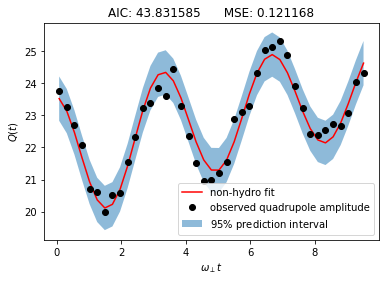

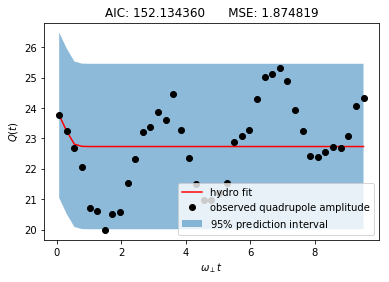

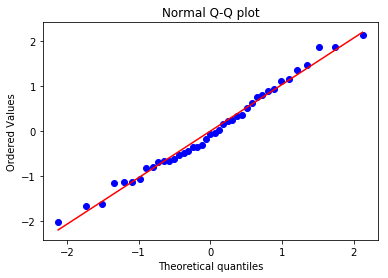

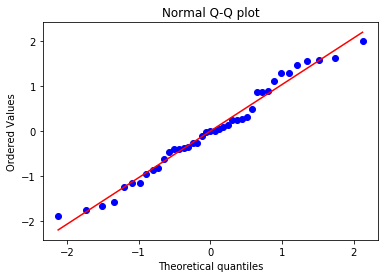

In [16]:
print('Best NH MSE:',nh_best_mse)
print('Best H MSE:',h_best_mse)
nh_err=np.std(yact-nh_best_y,ddof=1)
AIC_nh = 2*7-2*(-41/2*np.log(2*np.pi) - 41/2 * np.log(nh_err**2) - 41*nh_best_mse/(2*nh_err**2))
plt.plot(time,nh_best_y,c='r',label='non-hydro fit')
plt.fill_between(time.reshape(41),(nh_best_y - 1.96*nh_err).reshape(41),
                 (nh_best_y + 1.96*nh_err).reshape(41),alpha=0.5,label = r'$95\%$ prediction interval')
plt.plot(time,qm,'o',c='k',label='observed quadrupole amplitude')
plt.legend(loc=4)
plt.xlabel(r'$\omega_\perp t$')
plt.ylabel(r'$Q(t)$')
plt.title('AIC: %f'%AIC_nh + '      ' 'MSE: %f'%nh_best_mse)
plt.show()

h_err=np.std(yact-h_best_y,ddof=1)
AIC_h = 2*5-2*(-41/2*np.log(2*np.pi) - 41/2 * np.log(h_err**2) - 41*h_best_mse/(2*h_err**2))
plt.plot(time,h_best_y,c='r',label='hydro fit')
plt.fill_between(time.reshape(41),(h_best_y - 1.96*h_err).reshape(41),
                 (h_best_y + 1.96*h_err).reshape(41),alpha=0.5,label = r'$95\%$ prediction interval')
plt.plot(time,qm,'o',c='k',label='observed quadrupole amplitude')
plt.legend(loc=4)
plt.xlabel(r'$\omega_\perp t$')
plt.ylabel(r'$Q(t)$')
plt.title('AIC: %f'%AIC_h + '      ' 'MSE: %f'%h_best_mse)
plt.show()
import scipy.stats as stats
obs = (nh_best_y-qm.reshape(-1,1))
z = ((obs-np.mean(obs))/np.std(obs)).reshape(-1)

stats.probplot(z, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()
obs = (h_best_y-qm.reshape(-1,1))
z = ((obs-np.mean(obs))/np.std(obs)).reshape(-1)

stats.probplot(z, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [17]:
print('Non-hydro fit:','hydro frequency:',nh_best_f1[0][0],'hydro damping',nh_best_g1[0][0])
print('Non-hydro fit:','hydro frequency:',h_best_f1[0][0],'hydro damping',h_best_g1[0][0])

Non-hydro fit: hydro frequency: 1.8660704 hydro damping 0.040507667
Non-hydro fit: hydro frequency: -3.271685 hydro damping 8.676771


In [18]:
nh_best_amp2/nh_best_amp1

array([[-1.9408724]], dtype=float32)

In [19]:
nh_best_g2

array([[0.08817372]], dtype=float32)

In [20]:
nh_best_amp2

array([[-4.0176506]], dtype=float32)

In [21]:
nh_best_y-1.96 *nh_err

array([[22.833176],
       [22.445034],
       [21.782444],
       [20.99065 ],
       [20.236195],
       [19.675127],
       [19.423788],
       [19.53765 ],
       [20.00199 ],
       [20.73603 ],
       [21.609392],
       [22.467634],
       [23.161827],
       [23.576511],
       [23.650858],
       [23.389093],
       [22.858482],
       [22.175457],
       [21.482752],
       [20.921997],
       [20.607046],
       [20.603045],
       [20.915077],
       [21.488346],
       [22.21964 ],
       [22.977705],
       [23.628529],
       [24.06065 ],
       [24.205763],
       [24.050764],
       [23.639189],
       [23.061943],
       [22.439276],
       [21.89754 ],
       [21.545286],
       [21.453127],
       [21.641151],
       [22.076092],
       [22.67861 ],
       [23.339132],
       [23.939064]], dtype=float32)

In [22]:
2*7-2*(-41/2*np.log(2*np.pi) - 41/2 * np.log(nh_err**2) - 41*nh_best_mse/(2*nh_err**2))

43.831584551835654

In [23]:
2*5-2*(-41/2*np.log(2*np.pi) - 41/2 * np.log(h_err**2) - 41*h_best_mse/(2*h_err**2))

152.13436009295913

In [24]:
X = tf.placeholder(tf.float32, shape = (None, 1), name = 'X')
y = tf.placeholder(tf.float32, shape = (None,1),name = 'y')
amp1 = tf.Variable(nh_best_amp1[0][0],dtype = tf.float32,name='amp1')
amp2 = tf.Variable(nh_best_amp2[0][0],dtype = tf.float32,name='amp2')
offset = tf.Variable(nh_best_offset[0][0],dtype = tf.float32,name='offset')
f1 = tf.Variable(nh_best_f1[0][0],dtype = tf.float32,name='f1')
g1 = tf.Variable(nh_best_g1[0][0],dtype = tf.float32,name='g1')
g2 = tf.Variable(nh_best_g2[0][0],dtype = tf.float32,name='g2')
p1 = tf.Variable(nh_best_p1[0][0],dtype = tf.float32,name='p1')
# term1osc = tf.multiply(amp1,tf.cos(f1*t + p1,name='hydroosc'),name = 'term1osc')
# term1damp = tf.exp(-g1*t,name='hydrodamp')
term1osc = tf.multiply(amp1,tf.cos(f1*X + p1,name='hydroosc'),name = 'term1osc')
term1damp = tf.exp(-g1*X,name='hydrodamp')
term1 = tf.multiply(term1osc,term1damp,name = 'term1')
# term2 = tf.multiply(amp2,tf.exp(-g2*t,name='hydrodamp'),name = 'term2')
term2 = tf.multiply(amp2,tf.exp(-g2*X,name='hydrodamp'),name = 'term2')
no_offset = tf.add(term1,term2,name='no_offset')
y_pred = tf.add(no_offset,offset,name = 'predictions')
loglike = tf.log(tf.exp(-(y-y_pred)**2/(2*nh_err**2),name='exp'),name='loglike')
def full_hess(logl,params):
    
    my_rows = []
    for param in params:
        row = tf.gradients(
            tf.gradients(
                loglike,[param], 
                stop_gradients=[param])
            ,[amp1,amp2,offset,f1,g1,g2,p1], stop_gradients=[amp1,amp2,offset,f1,g1,g2,p1])
            
        my_rows.extend([row])
    
    return my_rows
    
# def compute_hessian(fn, vars):
#     mat = []
#     for v1 in vars:
#         temp = []
#         for v2 in vars:
#             # computing derivative twice, first w.r.t v2 and then w.r.t v1
#             temp.append(tf.gradients(tf.gradients(fn, v2)[0], v1)[0])
#         temp = [cons(0) if t == None else t for t in temp] # tensorflow returns None when there is no gradient, so we replace None with 0
#         #temp = tf.pack(temp)
#         mat.append(temp)
#     mat = tf.pack(mat)
#     return mat
hessian = full_hess(loglike, [amp1,amp2,offset,f1,g1,g2,p1])
#secondgrads = tf.gradients(grads,[amp1,amp2,offset,f1,g1,g2,p1], stop_gradients=[amp1,amp2,offset,f1,g1,g2,p1])
#likelihood = tf.multiply(1/np.sqrt(2*np.pi*nh_err**2),exponential,name='likelihood')
#likelihood = tf.multiply((1/np.sqrt(2*np.pi*nh_err**2))**41,exponential)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    
    sess.run(init)
    
    final = sess.run(hessian,feed_dict={X:time.reshape(-1,1),
                                     y:yact})

In [25]:
params = ['amp1','amp2','offset','f1','g1','g2','p1']
best_params = [nh_best_amp1[0][0],nh_best_amp2[0][0],
               nh_best_offset[0][0],nh_best_f1[0][0],
               nh_best_g1[0][0],nh_best_g2[0][0],nh_best_p1[0][0]]
for i in range(0,7):
    print(params[i]+':',best_params[i],'+/-',np.sqrt(np.linalg.inv(-1*np.asmatrix(final))[i,i]))

amp1: 2.070023 +/- 0.1747620443910722
amp2: -4.0176506 +/- 1.1860539478610248
offset: 25.549559 +/- 1.240464725076256
f1: 1.8660704 +/- 0.017425319985490153
g1: 0.040507667 +/- 0.01746463418750483
g2: 0.088173725 +/- 0.03993177683144547
p1: 6.4479246 +/- 0.08981479146910136


In [170]:
nh_best_amp1[0][0]

2.0666535

In [194]:
a = []
a.extend([[1]])

In [195]:
a

[[1]]

In [197]:
a.extend([[2]])

In [198]:
a

[[1], [2]]

In [245]:
final

[[-54.13697, -8.716792, 35.47356, 21.338058, 423.81384, 2.248733, -10.944607],
 [-8.716792,
  -18.4192,
  -34.821686,
  -31.0421,
  -3.9302344,
  -6.9319935,
  -127.43941],
 [35.473553,
  -34.821686,
  -964.9036,
  -9.207679,
  -176.24812,
  -26.719425,
  -248.90709],
 [21.338064,
  -31.042103,
  -9.207634,
  -5178.0957,
  85.79717,
  -35.144115,
  -2006.2283],
 [423.8139, -3.930235, -176.24811, 85.79711, -5419.101, -22.63488, -98.58448],
 [2.248733,
  -6.9319925,
  -26.719425,
  -35.14412,
  -22.63488,
  -4.8979993,
  -82.05862],
 [-10.944598,
  -127.43941,
  -248.90707,
  -2006.2281,
  -98.584526,
  -82.05861,
  -1838.695]]

In [250]:
np.asmatrix(final)[:,:]

matrix([[-5.4136971e+01, -8.7167921e+00,  3.5473560e+01,  2.1338058e+01,
          4.2381384e+02,  2.2487330e+00, -1.0944607e+01],
        [-8.7167921e+00, -1.8419201e+01, -3.4821686e+01, -3.1042101e+01,
         -3.9302344e+00, -6.9319935e+00, -1.2743941e+02],
        [ 3.5473553e+01, -3.4821686e+01, -9.6490363e+02, -9.2076788e+00,
         -1.7624812e+02, -2.6719425e+01, -2.4890709e+02],
        [ 2.1338064e+01, -3.1042103e+01, -9.2076340e+00, -5.1780957e+03,
          8.5797173e+01, -3.5144115e+01, -2.0062283e+03],
        [ 4.2381390e+02, -3.9302349e+00, -1.7624811e+02,  8.5797112e+01,
         -5.4191011e+03, -2.2634880e+01, -9.8584480e+01],
        [ 2.2487330e+00, -6.9319925e+00, -2.6719425e+01, -3.5144119e+01,
         -2.2634880e+01, -4.8979993e+00, -8.2058617e+01],
        [-1.0944598e+01, -1.2743941e+02, -2.4890707e+02, -2.0062281e+03,
         -9.8584526e+01, -8.2058609e+01, -1.8386949e+03]], dtype=float32)